Kaggle is a great place for those who are trying to improve their data science/analytics skills. It has a huge number of public datasets you can download and use. You can use these Kaggle datasets without downloading them to your PC but by importing them to Google Colaboratory. Colab is a free Jupyter notebook environment and it runs entirely in the cloud. It allows you to write and execute Python code through the browser.


So, let’s see how you can easily import a Kaggle dataset to Colab and I will also provide some useful Python code to analyze the dataset you imported.


1. Copy the Kaggle API token
2. Go to your account and click on Create New API Token kaggle.json file will be downloaded.
3. Upload the kaggle.json file into your google colab
4. Now go to your Kaggle dataset and copy the API command.


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d projectshs/pizza-classification-data

brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  infl

In [ ]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

#The Dataset class
This is the core of our custom dataset. The structure of the dataset class is something like this:

<img src = 'https://miro.medium.com/max/380/1*atYFDNw1OFWjtH5wztDFgg.png'>

We create our BrainDataset class by inheriting the Dataset class:


In [ ]:
from torch.utils.data import Dataset


irst, we define the __init__ function. As soon as we 

---

create an instance of our LandMarkDataset class, this function is called by default. This function should contain all operations that we want to run on the whole dataset (eg. train) once. The usage of this will be more clear in the next part of this series where we create a custom machine translation dataset. For now, we define the variables for image_paths and transforms for the corresponding Train, Valid, and Test sets.

Then we have the __len__ function which just returns the length of the dataset. This is used afterward by the DataLoader to create batches.

And finally, we have __getitem__. This processes and returns 1 datapoint at a time.

In [ ]:
#######################################################
#               Define Dataset Class
#######################################################

class BrainDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label


    def get_labels(self, idx):
      image_filepath = self.image_paths[idx]
      label = image_filepath.split('/')[-2]
      label = class_to_idx[label]
      return label

In [ ]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = 'Training' 
test_data_path = 'Testing'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  Training/no_tumor/image(244).jpg
class example:  glioma_tumor
Train size: 2296
Valid size: 574
Test size: 394


In [ ]:
print(len(classes))

4


In [ ]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
print(class_to_idx)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


# Define Transform

Next, we define our augmentations using Albumentations. We define different augmentations for train and test. We apply transformations related to crop/rotation, colour/saturation, and brightness on training data. We also normalise both train and test data with image net mean and std deviation. Finally, we convert the data to PyTorch tensor using ToTensor().

In [ ]:
train_transforms = A.Compose(
    [
        A.Resize (height=100, width=100),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize (height=100, width=100),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = BrainDataset(train_image_paths,train_transforms)
valid_dataset = BrainDataset(valid_image_paths,train_transforms) #test transforms are applied
test_dataset = BrainDataset(test_image_paths,test_transforms)

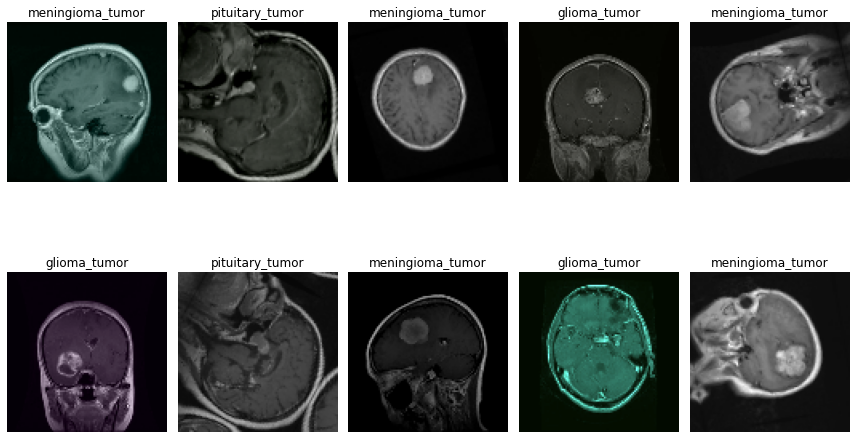

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

### Creating the DataLoader

The final step. DataLoader class is used to load data in batches for the model. This helps us processing data in mini-batches that can fit within our GPU’s RAM. First, we import the DataLoader:



In [ ]:
from torch.utils.data import DataLoader

In [ ]:
#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [ ]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}